# Мультиклассовая классификация

В этом ДЗ будем работать со следующим набором данных:
https://archive.ics.uci.edu/ml/datasets/car+evaluation

Будем предсказывать класс автомобиля по его характеристикам. Класс может быть unacceptable, acceptable, good, very good

Набор данных загружаем из .csv, предоставленного Вам для выполнения ДЗ.

0. Расположите все импорты под этой клеткой

In [76]:
import numpy as np
import pandas as pd
import seaborn as sns
import pydotplus
import warnings
from matplotlib import pyplot as plt
from pathlib import Path
from six import StringIO 
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import Pipeline
from IPython.display import Image  

warnings.filterwarnings('ignore')
%matplotlib inline

1.1.Загрузите набор данных в переменную df с помощью Pandas. Выведите первые 5 записей и форму набора данных.

In [2]:
DATA = Path('../data/')
df = pd.read_csv(DATA / 'cars_evaluation_data.csv')
df

,vhigh,vhigh.1,2,2.1,small,low,unacc
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc
...,...,...,...,...,...,...,...
1722,low,low,5more,more,med,med,good
1723,low,low,5more,more,med,high,vgood
1724,low,low,5more,more,big,low,unacc
1725,low,low,5more,more,big,med,good


1.2.В наборе данных нет названий колонок. Дайте следующие названия колонкам:
`['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']`

In [3]:
df_cols = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
df.columns = df_cols
df

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc
...,...,...,...,...,...,...,...
1722,low,low,5more,more,med,med,good
1723,low,low,5more,more,med,high,vgood
1724,low,low,5more,more,big,low,unacc
1725,low,low,5more,more,big,med,good


2. Выведите программно количество встречаний каждого значения каждой из независимых переменных. Формат числовой, не визуальный. Пример ответа для одной колонки:
```
med      432
high     432
vhigh    432
low      432
Name: buying, dtype: int64
```
Обязательно, чтоб были названия колонок, названия значений и количество строк с этим значением.

In [4]:
[print(f"{df.loc[:,col].value_counts()}\n") for col in df.columns if col != 'class'];

low      432
high     432
med      432
vhigh    431
Name: buying, dtype: int64

low      432
high     432
med      432
vhigh    431
Name: maint, dtype: int64

4        432
3        432
5more    432
2        431
Name: doors, dtype: int64

4       576
more    576
2       575
Name: persons, dtype: int64

med      576
big      576
small    575
Name: lug_boot, dtype: int64

high    576
med     576
low     575
Name: safety, dtype: int64



3.Выведите сколько строк соответствуют каждому из значений целевой переменной. Дайте ответы на два следующих вопроса:   
3.1. Данная переменная ординальная (порядковая) или номинальная? Почему?  
3.2. Классификация в данном случае будет сбалансированная или несбалансированная? Почему?

In [5]:
df.loc[:,'class'].value_counts()

unacc    1209
acc       384
good       69
vgood      65
Name: class, dtype: int64

3.1. Это ординальная переменная, поскольку ее значения (степень "приемлемости" авто) могут быть естественным образом упорядочены в порядке возрастания/убывания и промаркированы.  
3.2. Классификация несбалансированная из-за явного наличия мажоритарного (unacc) и миноритарного (good, vgood) классов

4.Проверьте, есть ли отсутствующие значения во всех переменных загруженного набора данных.

In [6]:
df.isna().sum()

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64

5.1.Запишите в переменную X все независимые переменные, в переменную y - целевую.

In [7]:
feature_columns = np.setdiff1d(df.columns, 'class')
X = df[feature_columns]
y = df['class']

5.2.Разбейте данные на тренировочный и тестовый наборы (мы снова игнорируем валидационных для упрощения задания). Определите random_state равным 42 и test_size равным 0.33.

In [8]:
test_size = 0.33
X_train_df, X_test_df, y_train, y_test = train_test_split (X, y, test_size = test_size, shuffle = True, random_state=42) 

5.3.Выведите форму и первые 5 записей полученных X_train_df, X_test_df.

In [9]:
#X_train_df
print(f"X_train shape = {X_train_df.shape}")
X_train_df.head()

X_train shape = (1157, 6)


,buying,doors,lug_boot,maint,persons,safety
83,vhigh,5more,med,vhigh,2,low
48,vhigh,3,med,vhigh,more,med
468,high,3,small,vhigh,4,med
155,vhigh,3,med,high,more,low
1043,med,4,small,high,more,low


In [10]:
#X_test_df
print(f"X_test shape = {X_test_df.shape}")
X_test_df.head()

X_test shape = (570, 6)


,buying,doors,lug_boot,maint,persons,safety
599,high,4,big,high,2,low
932,med,4,big,vhigh,4,low
628,high,5more,big,high,2,high
1497,low,5more,med,high,4,med
1262,med,4,med,low,more,low


6.1.Выведите типы данных всех переменных в X_train.

In [11]:
X_train_df.dtypes

buying      object
doors       object
lug_boot    object
maint       object
persons     object
safety      object
dtype: object

6.1. Все независимые переменные у нас ординальные. Закодируйте все независимые переменные используя подходящий метод из sklearn.preprocessing.  
Вам необходимо задать правильный порядок значений для каждой переменной при кодировке так, чтоб значения после кодирования были упорядочены в порядке возрастания.  
Кодирование значений {'high':1,'low':2,'med':3} будет считаться неправильным выполнением задания.
Подумайте, как корректно применять энкодер на трен. и тест. данных.
Результат кодирования X_train_df и X_test_df запишите соответственно в X_train, X_test.

In [45]:
low_vhigh_cat = ['low', 'med', 'high', 'vhigh']
doors_cat = ['2', '3', '4', '5more']
pers_cat = ['2', '4', 'more']
small_big_cat = ['small', 'med', 'big']

enc_categories = [low_vhigh_cat, doors_cat, small_big_cat, low_vhigh_cat, pers_cat, low_vhigh_cat]

ordinal_encoder = OrdinalEncoder(categories=enc_categories)

ordinal_encoder.fit(X_train_df)

X_train = ordinal_encoder.transform(X_train_df)
X_test = ordinal_encoder.transform(X_test_df)

6.2.Выведите первые 5 записей X_train, X_test.

In [46]:
X_train[:5], X_test[:5]

(array([[3., 3., 1., 3., 0., 0.],
        [3., 1., 1., 3., 2., 1.],
        [2., 1., 0., 3., 1., 1.],
        [3., 1., 1., 2., 2., 0.],
        [1., 2., 0., 2., 2., 0.]]),
 array([[2., 2., 2., 2., 0., 0.],
        [1., 2., 2., 3., 1., 0.],
        [2., 3., 2., 2., 0., 2.],
        [0., 3., 1., 2., 1., 1.],
        [1., 2., 1., 0., 2., 0.]]))

6.3.Выведите полученные категории энкодера.

In [47]:
encoder.categories_

[array(['low', 'med', 'high', 'vhigh'], dtype=object),
 array(['2', '3', '4', '5more'], dtype=object),
 array(['small', 'med', 'big'], dtype=object),
 array(['low', 'med', 'high', 'vhigh'], dtype=object),
 array(['2', '4', 'more'], dtype=object),
 array(['low', 'med', 'high', 'vhigh'], dtype=object)]

7.1.Обучите на полученных данных логистическую регрессию c параметрами по умолчанию. 

In [62]:
log_r = LogisticRegression(random_state=42).fit(X_train, y_train)

7.2.Сделайте предсказания с помощью полученной модели. 

In [63]:
train_predict = log_r.predict(X_train)
test_predict = log_r.predict(X_test)

7.3. Выведите метрики качества с помощью classification_report.

In [64]:
print(f"Train set:\n{classification_report(y_train, train_predict)}\n")
print(f"Test set:\n{classification_report(y_test, test_predict)}")

Train set:
              precision    recall  f1-score   support

         acc       0.67      0.58      0.62       257
        good       0.56      0.43      0.49        51
       unacc       0.88      0.93      0.90       810
       vgood       0.79      0.67      0.72        39

    accuracy                           0.82      1157
   macro avg       0.72      0.65      0.68      1157
weighted avg       0.81      0.82      0.82      1157


Test set:
              precision    recall  f1-score   support

         acc       0.66      0.60      0.63       127
        good       0.56      0.28      0.37        18
       unacc       0.88      0.93      0.90       399
       vgood       0.80      0.77      0.78        26

    accuracy                           0.83       570
   macro avg       0.72      0.64      0.67       570
weighted avg       0.82      0.83      0.82       570



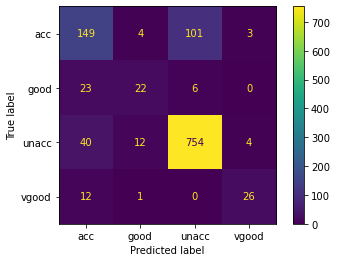

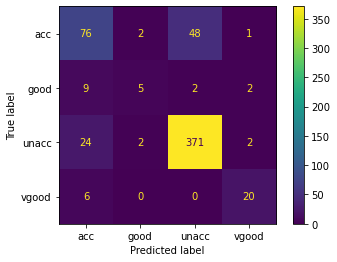

In [65]:
cm_train = confusion_matrix(y_train, train_predict) 
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=log_r.classes_)

cm_test = confusion_matrix(y_test, test_predict) 
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=log_r.classes_)

disp_train.plot()
disp_test.plot()

plt.show()

7.4.Какую метрику качества вы рекомендуете использовать для сравнения разных моделей и выбора лучшей? Почему? Метрика - это одно число, характеризирующее качество предсказаний модели.

**Weighted macro avarage по метрике f-score - по той причине, что классы несбалансированы; f-score - потому, что балансирует precision и recall. Таким образом, это значение метрики 0.82 для обеих - тестовой и тренировочной - выборок.**  

8.1.Обучите Decision Tree из sklearn с глубиной 4 на тех же данных. Подсчитайте предсказания, найдите метрику качества на test данных. Сравните с логистической регрессией. Какая модель лучше? Какие видите надочёты этой модели?

In [66]:
tree_clf = DecisionTreeClassifier(random_state=42, max_depth=4).fit(X_train, y_train)

In [67]:
tree_train_predict = tree_clf.predict(X_train)
tree_test_predict = tree_clf.predict(X_test)

In [68]:
print(classification_report(y_test, tree_test_predict))

              precision    recall  f1-score   support

         acc       0.75      0.72      0.74       127
        good       0.31      1.00      0.47        18
       unacc       0.96      0.94      0.95       399
       vgood       0.00      0.00      0.00        26

    accuracy                           0.85       570
   macro avg       0.51      0.67      0.54       570
weighted avg       0.85      0.85      0.84       570



Сравниваем по показателю weighted avarage f1; обе модели - логистическая регрессия и DT - показывают почти одинаковое качество (0.82 для логистической регрессии и 0.84 для DT). Хотя, если рассматривать показатели точности и покрытия по каждой категории в отдельности, то DT дает результаты ощутимо лучше (за исключением категории vgood).   
  
Недостатки DT: при заданных параметрах класс vgood вообще не был идентифицирован; кроме того, при 100% покрытии точность прогноза для категории good слишком низкая.

8.2.Выведите параметры модели Decision Tree.

In [69]:
tree_clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

8.3.Визуализируйте полученное дерево любым из существующих способов. На картинке должен быть граф с критериями в узлах, классами и количеством элементов в каждом листе.

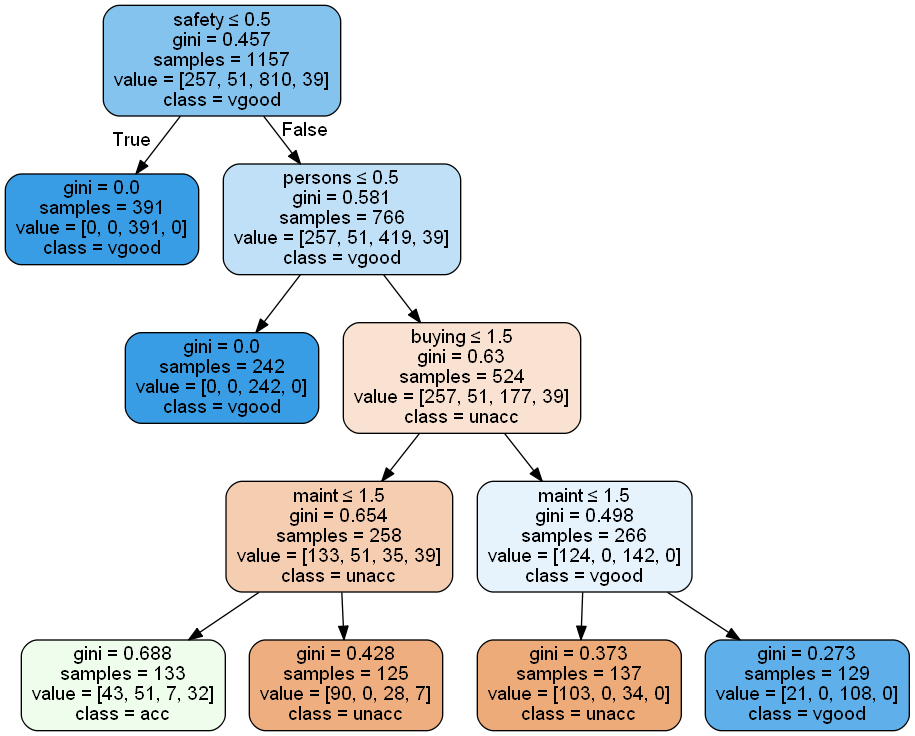

In [70]:
dot_data = StringIO()
export_graphviz(tree_clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names = feature_columns, 
                class_names=['unacc', 'acc', 'vgood', 'good'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('cars_evaluation.png')
Image(graph.create_png())

9.1.Выполните поиск гиперапарметров для DecisionTree по сетке с помощью sklearn. Задайте сетку из параметров самостоятельно исходя из предположений, что может дать улучшение работы дерева.  
Вам удалось найти модель, которая работает лучше, чем построенная в пункте 8.1?

In [71]:
dt = DecisionTreeClassifier(random_state=42)
param_grid = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'max_depth': np.arange(4,8,1),
              'max_leaf_nodes':[4,8,16,32],
              'max_features': ['sqrt', 'log2', None]
             }

search = GridSearchCV(dt, param_grid, cv = 5)

In [72]:
search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([4, 5, 6, 7]),
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': [4, 8, 16, 32],
                         'splitter': ['best', 'random']})

In [73]:
#предикт делаю на тестовых данных
best_model = search.best_estimator_
best_model_predict = best_model.predict(X_test)

9.2.Выведите claasification report финальной модели поиска гиперпараметров.

In [74]:
#данная модель гораздо лучше найденной в задании 8.1
print(classification_report(y_test, best_model_predict))

              precision    recall  f1-score   support

         acc       0.86      0.87      0.86       127
        good       0.52      0.67      0.59        18
       unacc       0.99      0.97      0.98       399
       vgood       0.71      0.77      0.74        26

    accuracy                           0.93       570
   macro avg       0.77      0.82      0.79       570
weighted avg       0.93      0.93      0.93       570



9.3. Выведите матрицу ошибок для лучшей модели в поиске гиперпараметров. Отобразите матрицу визуально (в виде графика с закрашеными по значениям клетками или в виде таблицы с закрашиванием фона).

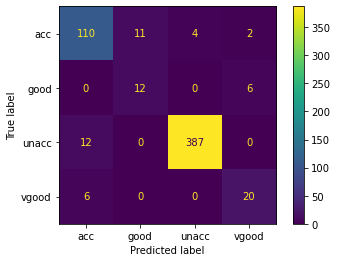

In [75]:
best_model_cm = confusion_matrix(y_test, best_model_predict)
disp_best_model = ConfusionMatrixDisplay(confusion_matrix=best_model_cm, display_labels=best_model.classes_)

disp_best_model.plot()

plt.show()

9.4.Сделайте вывод, какие классы с какими модель путает больше всего?

1. Unacceptable (unacc) и Acceptaple (acc) - всего 16 экземпляров  
2. Acceptaple (acc) и Good (good) - всего 11 экземпляров